# Hierarchical Linear Model for US Presidential Election Predictions using Probalistic Programming

In [1]:
from final_2016 import pass_data

/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import copy
from scipy.special import logit
from scipy.special import expit
from torch import cholesky

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from matplotlib import pyplot
from statsmodels.graphics.regressionplots import abline_plot


NaN = float('nan')

## Hierarchical Linear Model

Our goals are two-fold:
    1. is to translate The Economist's presidential election prediction model from R & Stan to Python & Pyro
    2. is to do a thorough evaluation of the results generated by the model and inference methods we have translated from the previous goal

In [3]:
# Creation of a covariance matrix of size (n, n) with variance sigma2 
def cov_matrix(n, sigma2, rho):
        m = np.ones(shape=(n,n)) * rho
        m2 = np.zeros(shape=(n,n))

        np.fill_diagonal(m, 1)
        np.fill_diagonal(m2, sigma2 ** .5) 
    
        return(np.matmul(np.matmul(m2, m), m2))

def check_cov_matrix(mat, weights):
        diag = np.diag(mat)

# Fitting RMSE linear regression with hardcoded param values & hyper param values
def fit_rmse_day_x(x):
        y = []
        for num in x:
                y.append( 0.03 + (10 **(-6.6)) * (num ** 2) )
        return y

## Model

The model that we have translated is a Dynamic Bayesian Model which is a bayesian network that relates the latent variables amongst themselves over adjacent time steps. The model has a backward component categorized by $y^d_i \sim \text{Binom}(n_i, \pi^d_{i,j})$, where $y^d_i$ is the number of voters in favor of a democrat, $n_i$ is the number of voters reporting a party preference, and $\pi^d_{i,j}$ is the share who would vote for democratic candidate on day $j$. The prior is $\pi^d_{i,j} = \text{logit}^{-1}(\beta_{i,j} + \delta_j)$ where $\beta_{i,j}$ is the state level effect and $\delta_j$ is the national level effect with priors defined on both of these R.V. as well. 

#### Abramovitz "Time for Change" Model

national_mu_prior = $x_0 + x_1 \cdot \text{juneapp} + x_2 \cdot \text{q2gdp}$

In [4]:
data, polls, res, dfTemp = pass_data()

                            OLS Regression Results                            
Dep. Variable:                incvote   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     25.15
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           1.62e-05
Time:                        05:06:51   Log-Likelihood:                -41.736
No. Observations:                  18   AIC:                             89.47
Df Residuals:                      15   BIC:                             92.14
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.6070      0.835     59.386      0.0

/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


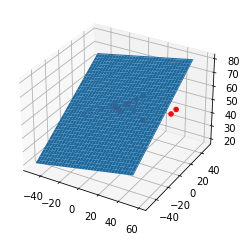

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfTemp['juneapp'], dfTemp['q2gdp'], dfTemp['incvote'], c='r', marker='o')

coefs = res.params
xs = np.tile(np.arange(101), (101,1)) - 50
ys = np.tile(np.arange(101), (101,1)).T - 50
national_mu_prior =  coefs["Intercept"] + coefs["juneapp"] * xs + coefs["q2gdp"] * ys

ax.plot_surface(xs,ys,national_mu_prior)
plt.show()

In [6]:
def convert_to_tensor(dic):
    for k, v in dic.items():
        dic[k] = torch.as_tensor(v)
    return dic

In [7]:
def model(data, polls=None):
    #data from data dictionary

    data = convert_to_tensor(data)
    
    #X
    N_national_polls = data["N_national_polls"] #Number of National Polls
    N_state_polls = 500
    #N_state_polls = data["N_state_polls"] #Number of State Polls
    T = data["T"] #Number of days
    S = data["S"] #Number of states for which at-least 1 poll is available
    P = data["P"] #Number of pollsters
    M = data["M"] #Number of poll modes
    Pop = data["Pop"] #Number of poll populations
    
    state = data["state"][:500] #state index
    day_state = data["day_state"][:500] #State Day index
    day_national = data["day_national"] #National Day index
    poll_state = data["poll_state"][:500] #State Pollster Index
    poll_national = data["poll_national"] #National Pollster Index
    poll_mode_state = data["poll_mode_state"][:500] #State Poll Mode Index
    poll_mode_national = data["poll_mode_national"] #National Poll Model Index
    poll_pop_state = data["poll_pop_state"][:500] #State poll population
    poll_pop_national = data["poll_pop_national"] #National Poll Populaiton
    unadjusted_national = data["unadjusted_national"] 
    unadjusted_state = data["unadjusted_state"][:500] 
    n_two_share_national = data["n_two_share_national"] #Total Number of Dem+Reb supporters for a particular poll
    n_two_share_state = data["n_two_share_state"][:500] #Total Number of Dem+Reb supporters for a particular poll

    
    #y
    if polls is not None:
        polls = convert_to_tensor(polls)
        n_democrat_national = polls["n_democrat_national"] #Number of Dem supporters in national poll for a particular poll 
        n_democrat_state = polls["n_democrat_state"][:500] #Number of Dem supporters in state poll for a particular poll
    else:
        n_democrat_national = None
        n_democrat_state = None
    
    #Prior Input values
    mu_b_prior = data["mu_b_prior"]
    state_weights = data["state_weights"]
    sigma_c = data["sigma_c"]
    sigma_m = data["sigma_m"]
    sigma_pop = data["sigma_pop"]
    sigma_measure_noise_national = data["sigma_measure_noise_national"]
    sigma_measure_noise_state = data["sigma_measure_noise_state"]
    sigma_e_bias = data["sigma_e_bias"]

    #Covariance Matrix and Scale Input
    state_covariance_0 = data["state_covariance_0"]
    random_walk_scale = data["random_walk_scale"]
    mu_b_T_scale = data["mu_b_T_scale"]
    polling_bias_scale = data["polling_bias_scale"]

    #Data Transformation
    national_cov_matrix_error_sd = torch.sqrt(state_weights.T @ state_covariance_0 @ state_weights)

    #Scale Covariance
    ss_cov_poll_bias = state_covariance_0 * (polling_bias_scale/national_cov_matrix_error_sd)**2
    ss_cov_mu_b_T = state_covariance_0 * (mu_b_T_scale/national_cov_matrix_error_sd)**2
    ss_cov_mu_b_walk = state_covariance_0 * (random_walk_scale/national_cov_matrix_error_sd)**2
    
    #Cholesky Transformation
    cholesky_ss_cov_poll_bias = torch.cholesky(ss_cov_poll_bias)
    cholesky_ss_cov_mu_b_T = torch.cholesky(ss_cov_mu_b_T)
    cholesky_ss_cov_mu_b_walk = torch.cholesky(ss_cov_mu_b_walk)

    #Priors
    #Parameters
    with pyro.plate("raw_mu_b_T-plate", size = S):
        raw_mu_b_T = pyro.sample("raw_mu_b_T", dist.Normal(0., 1.))
        #assert raw_mu_b_T.shape == (S,)
    
    with pyro.plate("raw_mu_b_y-plate", size = T):
        with pyro.plate("raw_mu_b_x-asis", size = S):
            raw_mu_b = pyro.sample("raw_mu_b", dist.Normal(0., 1.)) 
            #raw_mu_b.T.flatten() #Matrix to Column Order Vector
            
    with pyro.plate("raw_mu_c-plate", size = P):
        raw_mu_c = pyro.sample("raw_mu_c", dist.Normal(0., 1.))

    with pyro.plate("raw_mu_m-plate", size = M):
        raw_mu_m = pyro.sample("raw_mu_m", dist.Normal(0., 1.))

    with pyro.plate("raw_mu_pop-plate", size = Pop):
        raw_mu_pop = pyro.sample("raw_mu_pop", dist.Normal(0., 1.))

    #!Not sure if this satisfies Offset=0 and multiplier=0.02
    mu_e_bias = pyro.sample("mu_e_bias", dist.Normal(0., 0.02))*0.02 

    #!Need to find way to add constraint lower = 0, upper = 1
    rho_e_bias = pyro.sample("rho_e_bias", dist.Normal(0.7, 0.1)) 

    with pyro.plate("raw_e_bias-plate", size = T):
        raw_e_bias = pyro.sample("raw_e_bias", dist.Normal(0., 1.))

    with pyro.plate("raw_measure_noise_national-plate", size = N_national_polls):
        raw_measure_noise_national = pyro.sample("measure_noise_national", dist.Normal(0., 1.))
    
    with pyro.plate("raw_measure_noise_state-plate", size = N_state_polls):
        raw_measure_noise_state = pyro.sample("measure_noise_state", dist.Normal(0., 1.))

    with pyro.plate("raw_polling_bias-plate", size = S):
        raw_polling_bias = pyro.sample("raw_polling_bias", dist.Normal(0., 1.))

    #Transformed Parameters
    
    mu_b = pyro.deterministic('mu_b', torch.empty(S, T)) #initalize mu_b
    mu_b[:,T-1] = cholesky_ss_cov_mu_b_T @ raw_mu_b_T.double() + mu_b_prior
    for i in range(2,T):
        mu_b[:, T - i] = cholesky_ss_cov_mu_b_walk @ raw_mu_b[:, T - i].double() + mu_b[:, T + 1 - i]
    
    mu_c = pyro.deterministic('mu_c', raw_mu_c * sigma_c)
    mu_m = pyro.deterministic('mu_m', raw_mu_m * sigma_m) # mu_m is already in the trace as a sample
    mu_pop = pyro.deterministic('mu_pop', raw_mu_pop * sigma_pop)
    sigma_rho = pyro.deterministic('sigma_rho', torch.sqrt(1-(rho_e_bias)**2) * sigma_e_bias)
        
    e_bias = pyro.deterministic('e_bias', torch.empty(T)) #initalize e_bias
    e_bias[0] = raw_e_bias[0] * sigma_e_bias
    for t in range(1,T):
        e_bias[t] = mu_e_bias + rho_e_bias * (e_bias[t - 1] - mu_e_bias) + raw_e_bias[t] * sigma_rho

    # polling_bias is already in the trace as a sample
    polling_bias = pyro.deterministic('polling_bias', cholesky_ss_cov_poll_bias @ raw_polling_bias.double())
    #mu_b_Transpose = mu_b.t().detach() # type conversion satisfaction
    state_weights = state_weights # type conversion satisfaction 
    
    national_mu_b_average = pyro.deterministic('national_mu_b_average', mu_b.T.double() @ state_weights.double())
    national_polling_bias_average = pyro.deterministic('national_polling_bias_average',
                                               polling_bias.T.double() @ state_weights.double())


    logit_pi_democrat_state = pyro.deterministic('logit_pi_democrat_state', torch.zeros(N_state_polls))
    logit_pi_democrat_national = pyro.deterministic('logit_pi_democrat_national', torch.zeros(N_national_polls))

    #return torch.as_tensor(n_two_share_state), logit_pi_democrat_state
    
    for i in range(0, N_state_polls):
        logit_pi_democrat_state[i] = mu_b[state[i], day_state[i]] + mu_c[poll_state[i]] + mu_m[poll_mode_state[i]] + \
            mu_pop[poll_pop_state[i]] + unadjusted_state[i] * e_bias[day_state[i]] + raw_measure_noise_state[i] * sigma_measure_noise_state + \
            polling_bias[state[i]]
        
    logit_pi_democrat_national = national_mu_b_average[day_national] +  mu_c[poll_national] + mu_m[poll_mode_national] + \
        mu_pop[poll_pop_national] + unadjusted_national * e_bias[day_national] + raw_measure_noise_national * sigma_measure_noise_national +\
        national_polling_bias_average
    
    
    #Likelihood Of the Model
    #!need to verify if this is the correct implementation for binomial_logit of stan
    pyro.sample("n_democrat_state", dist.Binomial(n_two_share_state, logits = logit_pi_democrat_state), obs = n_democrat_state)
    #pyro.sample("n_democrat_national", dist.Binomial(n_two_share_national, logits = logit_pi_democrat_national), obs = n_democrat_national)  


In [8]:
#!Need to modify this based on hyper-parameters used by the Original Model
def Inference_MCMC(model, data, polls, n_samples = 500, n_warmup = 500, n_chains = 1):
    nuts_kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
    mcmc = MCMC(nuts_kernel, num_samples = n_samples, warmup_steps = n_warmup, num_chains = n_chains)
    mcmc.run(data, polls)
    
    # the samples that were not rejected; actual samples from the posterior dist
    posterior_samples = mcmc.get_samples()

    # turning to a dict
    hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

    return posterior_samples, hmc_samples


In [9]:
#Generate samples from posterior predictive distribution
def sample_posterior_predictive(model, posterior_samples, n_samples, data):
    posterior_predictive = Predictive(model, posterior_samples, num_samples = n_samples)(data, polls = None)

    return posterior_predictive

In [30]:
#Generating Quantity from posterior sample
def predicted_score(posterior_predictive):
    T = data['T']
    S = data['S']
    predicted = torch.empty(T, S)
    mu_b = posterior_predictive["mu_b"].squeeze().mean(axis=0)
    
    # just finding out value of latent variable mu_b; 
    # comes from the posteriors samples itself --> values of the parameters
    for s in range(S):
        predicted[:,s] = expit(mu_b[s,:])

    return predicted


### Here we are using the pass_data( ) function from our final_2016.py helper python file in order to abstract the extensive & dull data preprocessing needed before feeding into the model

In [12]:
posterior_samples, hmc_samples = Inference_MCMC(model, data, polls, 10, 10)

Sample: 100%|██████████| 20/20 [16:50, 50.51s/it, step size=2.78e-02, acc. prob=0.826]


In [13]:
posterior_samples.keys()

dict_keys(['raw_mu_b_T', 'raw_mu_b', 'raw_mu_c', 'raw_mu_m', 'raw_mu_pop', 'mu_e_bias', 'rho_e_bias', 'raw_e_bias', 'measure_noise_national', 'measure_noise_state', 'raw_polling_bias'])

In [18]:
posterior_predictive = sample_posterior_predictive(model, posterior_samples, 10, data)
posterior_predictive.keys()

dict_keys(['n_democrat_state', 'mu_b', 'mu_c', 'mu_m', 'mu_pop', 'sigma_rho', 'e_bias', 'polling_bias', 'national_mu_b_average', 'national_polling_bias_average', 'logit_pi_democrat_state', 'logit_pi_democrat_national'])

In [31]:
predicted = predicted_score(posterior_predictive)
predicted

tensor([[1.0000, 0.0069, 1.0000,  ..., 1.0000, 0.9981, 0.9983],
        [0.3748, 0.4138, 0.4408,  ..., 0.3502, 0.5221, 0.2754],
        [0.3748, 0.4138, 0.4408,  ..., 0.3502, 0.5221, 0.2754],
        ...,
        [0.3748, 0.4138, 0.4408,  ..., 0.3502, 0.5221, 0.2753],
        [0.3748, 0.4138, 0.4408,  ..., 0.3502, 0.5221, 0.2753],
        [0.3748, 0.4138, 0.4408,  ..., 0.3502, 0.5221, 0.2753]])

In [20]:
predicted.shape

torch.Size([539, 51])

In [29]:
posterior_predictive['mu_b'][5:].squeeze().mean(axis=0)

tensor([[ 0.4000, -0.5116, -0.5116,  ..., -0.5118, -0.5118, -0.5118],
        [ 0.4000, -0.3482, -0.3482,  ..., -0.3483, -0.3483, -0.3483],
        [ 0.4000, -0.2377, -0.2377,  ..., -0.2379, -0.2379, -0.2379],
        ...,
        [ 0.4000, -0.6180, -0.6180,  ..., -0.6182, -0.6182, -0.6182],
        [ 0.4000,  0.0886,  0.0886,  ...,  0.0885,  0.0885,  0.0885],
        [ 0.4000, -0.9675, -0.9675,  ..., -0.9677, -0.9677, -0.9677]])

In [ ]:
from collections import defaultdict

# ~~~ example ~~~~
#plot next to the prior distribution to see if there is some sort of improvement 

preds = defaultdict(list)
for i in range(len(predicted)):
    temp = predicted[i]
    for j in range(len(temp)):
        preds[j].append(temp[j])

for j in range(len(preds)):   
    plt.hist(preds[j], bins='auto', edgecolor='black', linewidth=0.75)
    plt.title("mu_b_T")
    plt.show()

In [ ]:
EV_Index = {0:"AL", 1:"AK", 2:"AZ", 3:"AK", 4:"CA", 5:"CO", 6:"CT", 7: "DC", 8:"DE", 9:"FL", 10:"GA", 11:"HI", 
    12:"ID", 13:"IL", 14:"IN", 15:"IA", 16:"KS", 17:"KY", 18:"LA", 19:"ME", 20:"MD", 21:"MA", 22:"MI", 23:"MN",
    24:"MS", 25:"MO", 26:"MT", 27:"NE", 28:"NV", 29:"NH", 30:"NJ", 31:"NM", 32:"NY", 33:"NC", 34:"ND", 
    35:"OH", 36:"OK", 37:"OR", 38:"PA", 39:"RI", 40:"SC", 41:"SD", 42:"TN", 43:"TX", 44:"UT", 45:"VT", 
    46:"VA", 47:"WA", 48:"WV", 49:"WI", 50:"WY",} 

EV = {"AK": 9, "AL": 13, "AZ": 11, "AK": 6, "CA": 55, "CO":9, "CT": 7, "DE": 3, "FL": 29, "GA": 16, "HI": 4, 
    "ID": 4, "IL": 20, "IN": 11, "IA": 6, "KS": 6, "KY": 8, "LA": 8, "ME": 4, "MD": 10, "MA": 11, "MI": 16, "MN": 10,
    "MS": 6, "MO": 10, "MT": 3, "NE": 5, "NV": 6, "NH": 4, "NJ": 14, "NM": 5, "NY": 29, "NC": 15, "ND": 3, 
    "OH": 18, "OK": 7, "OR": 7, "PA": 20, "RI": 4, "SC": 9, "SD": 3, "TN": 11, "TX": 38, "UT": 6, "VT": 3, 
    "VA": 13, "WA": 12, "WV": 5, "WI": 10, "WY": 3, "DC": 3}

In [ ]:
EV = data["state_weights"]

In [ ]:
plt.hist(preds[0], bins='auto', edgecolor='black', linewidth=0.75)
plt.title("mu_b_T")
plt.show()

In [ ]:
numDays = len(preds[0])
numStates = len(preds)

clintonWins = 0
trumpWins = 0
for i in range(numDays):
    evTotal = 0
    evTotal2 = 0
    for j in range(numStates):
        pct = preds[j][i]
        if pct >= 0.5:
            evTotal2 += EV[EV_Index[j]]
        else:
            evTotal += EV[EV_Index[j]]
    evTotal = int(evTotal)
    evTotal2 = int(evTotal2)
    if evTotal > evTotal2:
        clintonWins += 1
    else:
        trumpWins += 1
print(clintonWins, trumpWins)   




In [ ]:
print(len(hmc_samples))
print(hmc_samples.keys())

In [ ]:
print(len(hmc_samples["mu_b_T"]))

In [ ]:
predictions = hmc_samples["mu_b_T"]

preds = defaultdict(list)
for i in range(len(predictions)):
    temp = predictions[i]
    for j in range(len(temp)):
        preds[j].append(expit(temp[j]))

for j in range(len(preds)):   
    plt.hist(preds[j], bins='auto', edgecolor='black', linewidth=0.75)
    plt.title("mu_b_T")
    plt.show()